# **1.Xây dựng môi trường**



In [87]:
## Môi trường lập trình
from google.colab import drive
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/Năm IV/Big Data/Crawl'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
pip install -q underthesea

In [89]:
!pip install -q emoji
!pip install -q vncorenlp
!git clone https://github.com/vncorenlp/VnCoreNLP.git

fatal: destination path 'VnCoreNLP' already exists and is not an empty directory.


In [90]:
!pip install scikit-learn


In [91]:
!pip install h5py


In [92]:
import pandas as pd
import os
import regex
import re
import underthesea
import tensorflow as tf
import numpy as np
import string
from keras.models import load_model
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from underthesea import text_normalize
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import warnings
import joblib
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.metrics         import auc, roc_curve
from sklearn.metrics         import precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, make_scorer
from tabulate import tabulate  # Install using: pip install tabulate
# Tắt tất cả cảnh báo
warnings.filterwarnings("ignore")

# **2. Chuẩn bị dữ liệu**

In [93]:
df = pd.read_csv(folder + '/Data/UIT.csv')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6774 entries, 0 to 6773
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      6774 non-null   int64 
 1   comment    6774 non-null   object
 2   n_star     6774 non-null   int64 
 3   date_time  6774 non-null   object
 4   label      6774 non-null   object
dtypes: int64(2), object(3)
memory usage: 264.7+ KB


In [95]:
df.drop(['index','date_time','label'], axis=1, inplace=True)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6774 entries, 0 to 6773
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  6774 non-null   object
 1   n_star   6774 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 106.0+ KB


In [97]:
# Đếm số lượng bản ghi của từng mức sao trong cột 'n_star'
n_star_counts = df['n_star'].value_counts()
print(n_star_counts)

4    1454
1    1443
5    1413
2    1296
3    1168
Name: n_star, dtype: int64


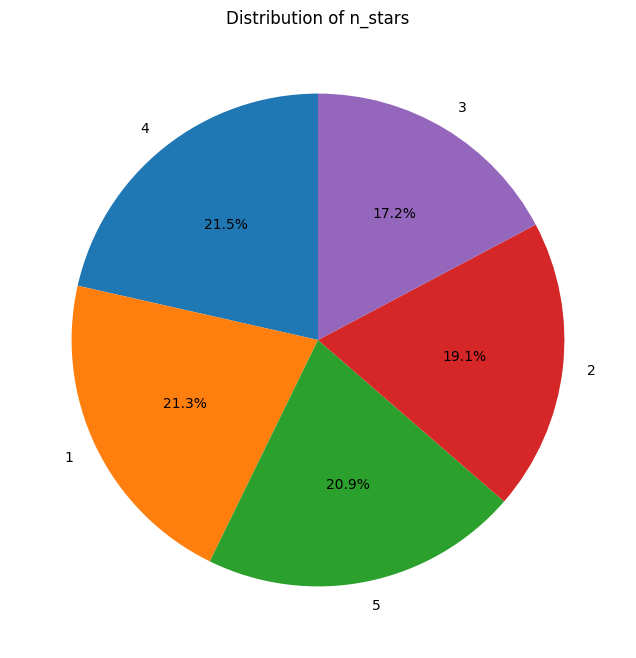

In [98]:
# Tính toán số lượng của mỗi đánh giá
n_star_counts = df['n_star'].value_counts()

# Biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(n_star_counts, labels=n_star_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of n_stars')
plt.show()

---
# **3. Tiền xử lý dữ liệu**
---
Tiền xử lý dữ liệu tiếng Việt cho bài toán phân loại văn bản gồm các việc sau:
 * Chuẩn hóa bảng mã Unicode (đưa về Unicode tổ hợp dựng sẵn)
 * Chuẩn hóa kiểu gõ dấu tiếng Việt (dùng òa úy thay cho oà uý)
 * Thực hiện tách từ tiếng Việt (sử dụng thư viện tách từ như pyvi, underthesea, vncorenlp,…)
 * đưa về văn bản lower (viết thường)
 * Xóa các ký tự đặc biệt: “.”, “,”, “;”, “)”, …
 * Loại bỏ stopword

## 3.1. Kiểm tra bộ dữ liệu

### Kiểm tra null

In [99]:
null_comment = df['comment'].isnull().sum()
print("Số lượng giá trị null trong cột 'comment':", null_comment)

Số lượng giá trị null trong cột 'comment': 0


In [100]:
df['comment'] = df['comment'].astype(str)

def cleaner_update(text):
    return text.translate(str.maketrans('','', string.punctuation)).lower()

tokenize_df=[]
for i in range(0,len(df)):
    clean = cleaner_update(df['comment'][i])
    tokenize_df.append(underthesea.word_tokenize(clean))
print(tokenize_df)

[['sao', 'lúc', 'gọi', 'điện thoại', 'màn hình', 'bị', 'chấm', 'nhỏ', 'nháy', 'gần', 'camera', 'trước', 'vậylúc', 'có', 'lúc', 'không'], ['mọi', 'người', 'cập nhật', 'phần mềm', 'lại', 'nó', 'sẽ', 'bớt', 'tốn', 'pin', 'mình', 'đã', 'thử', 'rồi', 'mọi', 'thứ', 'cũng', 'ok', 'nhưng', 'vân', 'tay', 'ko', 'nhạy'], ['mình', 'mới', 'xài', 'được', '7', 'tháng', 'xuống', '7', 'pin', 'chả', 'hiểu', 'máy', 'mới', 'kiểu', 'gì', 'nữa', 'dùng', 'cơ bản', 'lướt web', 'cơ bản', 'game', 'ko', 'chơi'], ['hôm qua', 'ngày', '2362020', 'e', 'ra', 'thế giới', 'di động', 'mua', 'chiếc', 'dthoai', 'galaxy', 'a51', 'lúc', 'đầu', 'bên', 'cửa hàng', 'báo giá', '779000', 'đ', 'được', 'tặng', 'phiếu', 'mua', 'hàng', '250', 'k', 'lúc', 'thanh toán', 'thì', 'nhân viên', 'lại', 'thanh toán', '7990000', 'đ', 'không', 'có', 'phiếu', 'mua', 'hàng', 'đi', '20', 'km', 'xuống', 'mua', 'thoai', 'tối', 'về', 'đến', 'nhà', 'nhân viên', 'mới', 'gọi', 'đến', 'có', 'xin lỗi', 'vì', 'sai xót', 'và', 'bảo', 'mình', 'xuống', 'đó',

In [101]:
words=[]
for m in range(0,len(tokenize_df)):
    for n in range(0,len(tokenize_df[m])):
        words.append(tokenize_df[m][n])
print(words)

['sao', 'lúc', 'gọi', 'điện thoại', 'màn hình', 'bị', 'chấm', 'nhỏ', 'nháy', 'gần', 'camera', 'trước', 'vậylúc', 'có', 'lúc', 'không', 'mọi', 'người', 'cập nhật', 'phần mềm', 'lại', 'nó', 'sẽ', 'bớt', 'tốn', 'pin', 'mình', 'đã', 'thử', 'rồi', 'mọi', 'thứ', 'cũng', 'ok', 'nhưng', 'vân', 'tay', 'ko', 'nhạy', 'mình', 'mới', 'xài', 'được', '7', 'tháng', 'xuống', '7', 'pin', 'chả', 'hiểu', 'máy', 'mới', 'kiểu', 'gì', 'nữa', 'dùng', 'cơ bản', 'lướt web', 'cơ bản', 'game', 'ko', 'chơi', 'hôm qua', 'ngày', '2362020', 'e', 'ra', 'thế giới', 'di động', 'mua', 'chiếc', 'dthoai', 'galaxy', 'a51', 'lúc', 'đầu', 'bên', 'cửa hàng', 'báo giá', '779000', 'đ', 'được', 'tặng', 'phiếu', 'mua', 'hàng', '250', 'k', 'lúc', 'thanh toán', 'thì', 'nhân viên', 'lại', 'thanh toán', '7990000', 'đ', 'không', 'có', 'phiếu', 'mua', 'hàng', 'đi', '20', 'km', 'xuống', 'mua', 'thoai', 'tối', 'về', 'đến', 'nhà', 'nhân viên', 'mới', 'gọi', 'đến', 'có', 'xin lỗi', 'vì', 'sai xót', 'và', 'bảo', 'mình', 'xuống', 'đó', 'nhận'

### Xem tất cả các từ

In [102]:
def df_count_word(words_list):
  df_count = pd.DataFrame(words_list,columns=['word'])
  df_count = df_count['word'].value_counts().reset_index()
  df_count.columns = ['word', 'count']
  return df_count

def WordCloudvisualization(df_count):
  # Chuyển DataFrame thành Dictionary để sử dụng cho WordCloud
  word_dict = dict(zip(df_count['word'], df_count['count']))

  # Tạo WordCloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

  # Vẽ biểu đồ WordCloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

def WordLine(df_count):
    # Vẽ biểu đồ đường
    plt.plot(df_count['word'], df_count['count'], linestyle='-', color='b', label='Dữ liệu mẫu')

    # Đặt tên cho trục x và y
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')

    # Thêm tiêu đề cho biểu đồ
    plt.title('Biểu đồ đường theo thứ tự tăng dần của X')

    # Hiển thị chú thích
    plt.legend()

    # Hiển thị biểu đồ
    plt.show()

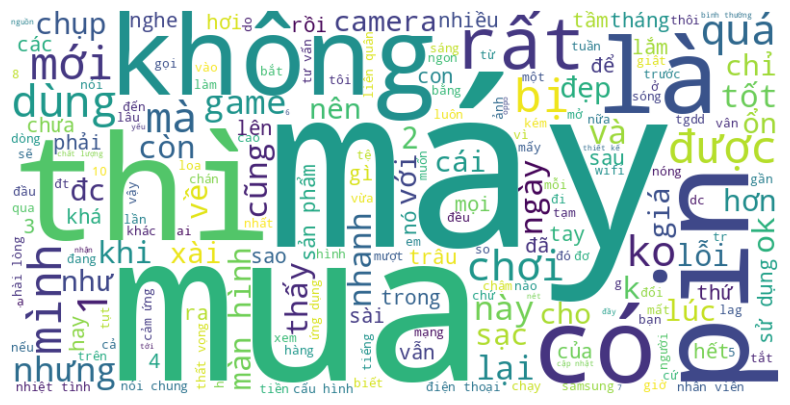

In [103]:
WordCloudvisualization(df_count_word(words))

## 3.2.Xử lý tiếng Việt


###Xử lý láy âm tiết

In [104]:
def handle_repeated_syllables(text):
    # Sử dụng regex để tìm các từ có âm tiết lặp lại (ví dụ: quááááá)
    repeated_syllables_pattern = re.compile(r'(\w+?)\1+', re.UNICODE)
    # Hàm xử lý việc loại bỏ âm tiết lặp lại
    def handle_repetition(match):
        word = match.group(1)
        # Giữ lại chỉ một phần lặp lại và thêm vào từ gốc
        return word

    # Áp dụng hàm xử lý vào chuỗi
    processed_text = repeated_syllables_pattern.sub(handle_repetition, text)
    return processed_text
# Sử dụng hàm với ví dụ
input_text = "Ngooon quááááá điiiiiiii"
output_text = handle_repeated_syllables(input_text)
print(output_text)

Ngon quá đi


### Loại bỏ các common content

In [105]:
EMAIL = re.compile(r"([\w0-9_\.-]+)(@)([\d\w\.-]+)(\.)([\w\.]{2,6})")
URL = re.compile(r"https?:\/\/(?!.*:\/\/)\S+")
PHONE = re.compile(r"(09|01[2|6|8|9])+([0-9]{9})\b")
MENTION = re.compile(r"@.+?:")
NUMBER = re.compile(r'\b\d+\S*\b')
DATETIME = '\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}'

# Delete price, 3g/4g/5g
PRICE = r'\b\d{1,4}(?:\.\d{3})*(?:\.\d+)?(?:[ktrđg])\b'

def replace_common_token(txt):
    txt = re.sub(EMAIL, ' ', txt)
    txt = re.sub(URL, ' ', txt)
    txt = re.sub(MENTION, ' ', txt)
    txt = re.sub(DATETIME, ' ', txt)
    txt = re.sub(NUMBER, ' ', txt)
    txt = re.sub(PRICE, ' ', txt)
    return txt

# Ví dụ sử dụng
text = "máy mạnh mượt trong tầm giá 3g nay 0889273527 jk mua khanhphuhv@gmail.com được giảm giá 300k còn 2690k thôi cấu hình mạnh chơi liên quân mượt nhân viên vui vẻ nhiệt tình về camera thì tạm thôi pin cực kì trâu nhưng không có sạc nhanh trải nghiệm thì thấy tất cả điều ổn ai chơi game thì chọn con này chứ chụp hình thì đừng nên mua hi vọng sài lâu không bị lỗi gì . "
text = """Mua được gần tháng từ ngày 15/7/2023 cảm thấy hài lòng
Pin trâu chơi liên quân bằng 3g liên tục đk 6-7 tiếng vẫn còn gần 40% pin
Máy đẹp sạc từ 30% lên 100% có gần 2 tiếng là đầy
Nhân viên chu đáo nhiệt tình"""
text_replace_common_token = text_normalize(handle_repeated_syllables(replace_common_token(text)))
print(text_replace_common_token)

Mua được gần tháng từ ngày cảm thấy hài lòng Pin trâu chơi liên quân bằng liên tục đk tiếng vẫn còn gần % pin Máy đẹp sạc từ % lên % có gần tiếng là đầy Nhân viên chu đáo nhiệt tình


### Loại bỏ dấu câu và ký tự xuống dòng

In [106]:
def remove_unnecessary_characters(text):
    RE_CLEAR = re.compile("[\n\r]+")# Thay thế các chuỗi xuống dòng (\n hoặc \r) bằng một ký tự trắng
    text = re.sub(RE_CLEAR, ' ', text)
    # Sử dụng string.punctuation để lấy tất cả các ký tự dấu câu
    translator = str.maketrans('', '', string.punctuation)
    # Loại bỏ dấu câu từ văn bản sử dụng bảng dịch (translator)
    text = text.translate(translator)

    return text

# Ví dụ sử dụng
text = """Đây là một đoạn__' văn bản,
 có chứa dấu câu! Xin chào các bạn."""
text_without_punctuation = remove_unnecessary_characters(text)
print(text_without_punctuation)

Đây là một đoạn văn bản  có chứa dấu câu Xin chào các bạn


### Chuẩn hóa các từ viết tắt cơ bản


In [107]:
# (Ví dụ: k, ko, k0 --> không, bt --> bình thường,...)

In [108]:
def normalize_acronyms(text, teencode_file=folder+'/Data/teencode.xlsx'):
    # Đọc dữ liệu từ tệp Excel teencode.xlsx
    teencode_df = pd.read_excel(teencode_file, header=None, names=['teencode', 'replace'])

    words = []
    for word in text.strip().split():
        word = word.strip(string.punctuation)
        # Tìm kiếm trong teencode_df và thay thế
        replacement = teencode_df.loc[teencode_df['teencode'].str.lower() == word, 'replace'].values
        if len(replacement) > 0:
            words.append(replacement[0])
        else:
            words.append(word)

    return ' '.join(words)

# Sử dụng hàm normalize_acronyms với tệp Excel teencode.xlsx
input_text = "ko biết tại sao ad tại ntn"
output_text = normalize_acronyms(input_text)
print(output_text)

không biết tại sao admin tại như thế nào


## **Tổng hợp lần 1**

In [109]:
def text_preprocess(text):
    # 1. Chuẩn hóa văn bản tiếng việt
    text = text_normalize(text)
    # 2. Xử lý láy âm tiết
    text = handle_repeated_syllables(text)
    # 3. Loại bỏ các common token
    text = replace_common_token(text)
    # 4. Xóa bỏ dấu câu
    text = remove_unnecessary_characters(text)
    # 5. Đưa về lower
    text = text.lower()
    # 6. Chuẩn hóa các từ viết tắt cơ bản
    text = normalize_acronyms(text)
    return text

# Sử dụng lớp TextPreprocess
text_to_preprocess = """Mua được gần tháng từ ngày 15/7/2023 cảm thấy hài lòng
Pin trâu chơi liên quân bằng 3g liên tục đk 6-7 tiếng vẫn còn gần 40% pin
Máy đẹp sạc từ 30% lên 100% có gần 2 tiếng là đầy
Nhân viên chu đáo nhiệt tình"""

preprocessed_text = text_preprocess(text_to_preprocess)
preprocessed_text

'mua được gần tháng từ ngày cảm thấy hài lòng pin trâu chơi liên quân bằng g liên tục được tiếng vẫn còn gần pin máy đẹp sạc từ lên có gần tiếng là đầy nhân viên chu đáo nhiệt tình'

In [110]:
df["comment_clean"] = df['comment'].apply(text_preprocess)
df

comment  n_star  \
0     Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...       3   
1     Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...       3   
2     Mình mới xài được 7 tháng xuống 7% pin. Chả hi...       1   
3     Hôm qua ngày 23/6/2020 e ra thế giới di động  ...       2   
4     Tại sao điện thoại mới mà sạc nó nóng máy lên ...       2   
...                                                 ...     ...   
6769  Máy cấu hình cao nhưng quá trình sủ dụng rất h...       2   
6770  Mình mới mua chưa đc 1 tuần.camera thì chụp hơ...       2   
6771  Pin tự nhiên nóng và tụt rất nhanh.ko khả thi ...       2   
6772  Đã mua hôm qua 24/04/2020. Trải nghiệm ko vừa ...       2   
6773  Điện thoại mới mua sài tạm ổn nhưng pin chắc d...       2   

                                          comment_clean  
0     sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...  
1     mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...  
2     mình mới xài được tháng xuống pin chả hiểu máy...  
3     hôm qua ngày em ra thế giới di động mua chiếc ...  
4     tại sao điện thoại mới mà sạc nó nóng máy lên ...  
...                                                 ...  
6769  máy cấu hình cao nhưng quá trình sủ dụng rất h...  
6770  mình mới mua chưa được tuần camera thì chụp hơ...  
6771  pin tự nhiên nóng và tụt rất nhanhko khả thi m...  
6772  đã mua hôm qua trải nghiệm không vừa ý pin tụt...  
6773  điện thoại mới mua xài tạm ổn nhưng pin chắc d...  

[6774 rows x 3 columns]

In [111]:
nan_values = df.isna().sum()
print(nan_values)

comment          0
n_star           0
comment_clean    0
dtype: int64


### Tải bộ từ điển tiếng việt

In [112]:
# Chia các từ trong cột "comment_clean" theo khoảng trắng
no_tokenize_df=[]
for i in range(0,len(df)):
    clean = cleaner_update(df['comment_clean'][i])
    no_tokenize_df.append(clean.split())

words_no_token=[]
for m in range(0,len(no_tokenize_df)):
    for n in range(0,len(no_tokenize_df[m])):
        words_no_token.append(no_tokenize_df[m][n])
df_words_no_token = df_count_word(words_no_token) # lấy tất cả các từ đơn trong df

In [113]:
# Lấy từ điển tiếng việt
vocabulary = []
file_path = folder + "/Data/words.txt"

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        # print(line.strip())
        vocabulary.append(line.strip())

vocab_in_dict = pd.DataFrame([json.loads(vocab) for vocab in vocabulary]) # Lấy thấy cả từ trong từ điển

In [114]:
# Chuyển thành các từ đơn và loại bỏ trùng lặp
vid = vocab_in_dict['text']
word_dict = []

for v in vid:
    word_dict += (v.lower().split(' '))

word_dict_ = list(set(word_dict))

In [115]:
# Chuẩn hóa cho các từ trong từ điển
word_dict = []
for word in word_dict_:
  word = text_normalize(word)
  word_dict.append(word)

In [116]:
# Kiểm tra những từ nào không có trong từ điển tiếng Việt
words_in_comment = df_words_no_token['word']
word_not_in_dict = []
for wic in words_in_comment:
    if wic not in word_dict:
        word_not_in_dict.append(wic)

In [117]:
# chuyển thành df và sắp xếp theo thứ tự alphabel
not_vietnamese = pd.DataFrame(word_not_in_dict, columns=['word'])
not_vietnamese.sort_values(by='word')

word
120     a1
156    a10
93    a10s
147    a12
959   a12s
...    ...
1398     🤧
366      🤨
405      🤮
632      🥴
1545     🥵

[2064 rows x 1 columns]

In [118]:
not_vietnamese.to_csv(folder+'/Data/not_vietnamese_UIT.csv')

In [119]:
not_vietnamese = pd.read_csv(folder + '/Data/not_vietnamese_UIT.csv')

### Xử lý các từ viết dính nhau

In [120]:
# Lấy các từ không phải tiếng việt dài hơn 6 (từ tiếng việt dài nhất là 6 chữ)
not_vietnamese_than_6 = not_vietnamese[not_vietnamese['word'].apply(lambda x: len(x) > 6)].reset_index(drop=True)
words_no_token_than_6=[]
for m in range(0,len(not_vietnamese_than_6)):
        words_no_token_than_6.append(not_vietnamese_than_6['word'][m].lower())
words_no_token_than_6

['samsung',
 'facebook',
 'youtube',
 'facebok',
 'android',
 'bluetoth',
 'mesenger',
 'thegioidong',
 'snapdragon',
 'smartphone',
 'youtobe',
 'comment',
 'blutoth',
 'blackbery',
 'onscren',
 'vinsmart',
 'mediatek',
 'ip7plus',
 'flagship',
 'megapixel',
 'bthuong',
 'youtubi',
 'note8pro',
 'iphone6',
 'naitrim',
 'vinaphone',
 'restore',
 'loading',
 'androi10',
 'frefire',
 'vietnam',
 'nhanhko',
 'reviewer',
 'mobistar',
 'active3',
 'smatphone',
 'options',
 'darkmode',
 'cạnhdưới',
 'not8pro',
 'mesenge',
 'dimensity',
 'pikachu',
 'lúcđang',
 'bluetoh',
 'youtuber',
 'vinmart',
 'realme3',
 'partner',
 'netflix',
 'androi7',
 'nhanhso',
 'websites',
 's20ultra',
 'snapdr85',
 'livetream',
 'zingmp3',
 'camrera',
 'pinmang',
 'pinthua',
 'feedback',
 'fulhdcon',
 'setings',
 'livestream',
 'zingmvp3',
 'experimental',
 'exelent',
 'maximum',
 'vsamart',
 'pasport',
 'dienmayxanhcom',
 'htpsyoutubecygvqdil4us',
 'thoigioidong',
 'hơinhanh',
 'tốtchụp',
 'đẹpchống',
 'nhanghe'

In [121]:
def stuck_words(text):
  for i in range(1,len(text)):
      word1 = text[:i]
      word2 = text[i:]
      if word1 in word_dict and word2 in word_dict:
          text_after = word1 + ' ' + word2
          return text_after
          break
text = 'khámbệnh'
stuck_words(text)

'khám bệnh'

In [122]:
# Gán các giá trị có thể tách ra vào cột mới stuck_word
not_vietnamese_than_6['stuck_word'] = float('nan')
for i in not_vietnamese_than_6['word']:
    not_vietnamese_than_6.loc[not_vietnamese_than_6['word'] == i, 'stuck_word'] = stuck_words(i)

In [123]:
df_stuck_words = not_vietnamese_than_6.dropna()
df_stuck_words # Bộ từ bị dính nhau và được tách ra trong df

Unnamed: 0         word    stuck_word
0             4      samsung      sam sung
31          506      nhanhko      nhanh ko
38          566     cạnhdưới     cạnh dưới
43          615      lúcđang      lúc đang
51          696      nhanhso      nhanh so
58          803      pinmang      pin mang
59          808      pinthua      pin thua
73          979     hơinhanh     hơi nhanh
74          980      tốtchụp      tốt chụp
75          986     đẹpchống     đẹp chống
76          990      nhanghe      nha nghe
78          998     tốtnhiều     tốt nhiều
80         1019      nghiêmh      nghiêm h
86         1034      phẩmvừa      phẩm vừa
94         1106      oknhung      ok nhung
95         1116    pincamera    pin camera
112        1238      kcamera      k camera
114        1257     thôngmạo     thông mạo
115        1258     khêquảng     khê quảng
116        1259     mọingươi     mọi ngươi
117        1271   trangphong   trang phong
126        1323      nhanhcn      nhanh cn
132        1353      sumsung      sum sung
133        1359      ngonpin      ngon pin
136        1366   ngoncamera   ngon camera
139        1392    thànhbình    thành bình
141        1397     loanhghe     loanh ghe
158        1489      mượtcao      mượt cao
167        1554      nhạchàn      nhạc hàn
168        1565      muatuần      mua tuần
170        1576      taymong      tay mong
182        1665     quyếtmáy     quyết máy
188        1705    nhanhchoi    nhanh choi
189        1717  nhanhcamera  nhanh camera
194        1744      ngheloa      nghe loa
196        1754     saotrong     sao trong
198        1774      nămđang      năm đang
208        1826      thuikhi      thui khi
210        1851     lênxuống     lên xuống
211        1855      ngàyđầu      ngày đầu
221        1941      hinhloa      hinh loa
225        1961     nhanhcon     nhanh con
237        2041     videocal     video cal

In [124]:
def normalize_stuck(text, df_stuck_words=df_stuck_words):
    words = []
    for word in text.strip().split():
        word = word.strip(string.punctuation)
        # Tìm kiếm trong teencode_df và thay thế
        replacement = df_stuck_words.loc[df_stuck_words['word'].str.lower() == word, 'stuck_word'].values
        if len(replacement) > 0:
            words.append(replacement[0])
        else:
            words.append(word)

    return ' '.join(words)

# Sử dụng hàm normalize_acronyms với tệp Excel teencode.xlsx
input_text = "không biết tại sao lại được giao hàngnhanh thế"
output_text = normalize_stuck(input_text)
print(output_text)

không biết tại sao lại được giao hàngnhanh thế


In [125]:
nan_values = df.isna().sum()
print(nan_values)

comment          0
n_star           0
comment_clean    0
dtype: int64


### Xử lý các từ không có nghĩa ít hơn 3 chữ

In [126]:
not_vietnamese_less_3 = not_vietnamese[not_vietnamese['word'].apply(lambda x: len(x) < 3)].reset_index(drop=True)
not_vietnamese_less_3

Unnamed: 0 word
0            28   ap
1            34   lq
2            35   ip
3            36    😊
4            37   j7
..          ...  ...
283        1978   ju
284        1984   i7
285        2028   đě
286        2036    😶
287        2046   k6

[288 rows x 2 columns]

In [127]:
not_vietnamese_less_3 = list(set(not_vietnamese_less_3['word']))
# Qua kiểm tra thấy các từ không phải tiếng việt ngắn hơn 3 hầu hết không có nghĩa, nên thực hiện đưa các từ này vào stopword để loại bỏ

In [128]:
nan_values = df.isna().sum()
print(nan_values)

comment          0
n_star           0
comment_clean    0
dtype: int64


### Loại bỏ các stopword tiếng Việt


In [129]:
def load_data(txt_file):
    """
    Each document is one line, documents is already preprocess like: remove truncate, tokenize, strip, ...
    :param txt_file: path/to/text/file
    :return: list of documents
    """
    texts = []
    with open(txt_file, 'r', encoding='utf8') as fp:
        for line in fp.readlines():
            texts.append(line.strip())
    return texts


def get_stopwords(documents, threshold=3):
    """
    :param documents: list of documents
    :param threshold:
    :return: list of words has idf <= threshold
    """
    tfidf = TfidfVectorizer(min_df=100)
    tfidf_matrix = tfidf.fit_transform(documents)
    features = tfidf.get_feature_names_out()
    stopwords = []
    print(min(tfidf.idf_), max(tfidf.idf_), len(features))
    for index, feature in enumerate(features):
        if tfidf.idf_[index] <= threshold:
            stopwords.append(feature)
    return stopwords


def check_stopwords_in_file(word_list, file_path):
    # Đọc nội dung từ file stopword.txt
    with open(file_path, 'r', encoding='utf-8') as file:
        stopword_content = file.read()

    # Kiểm tra từng từ trong danh sách
    stopwords_found = [word for word in word_list if word in stopword_content]

    return stopwords_found

# loại stopword khỏi dữ liệu
def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)

In [130]:
# Danh sách từ cần kiểm tra
stopwords = get_stopwords(load_data(folder + r"/Data/UITcontent.txt"), threshold=10)
# Đường dẫn đến file stopword.txt
stopword_file_path = folder + "/Data/stopwords.txt"
# Kiểm tra các từ trong danh sách có trong stopword.txt không
stopword = check_stopwords_in_file(stopwords, stopword_file_path)
# Hiển thị kết quả
print("Các từ có trong stopword.txt:", stopword)

1.8847841509050869 5.4120179109136615 394
Các từ có trong stopword.txt: ['ai', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'không', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để']


In [131]:
len(stopword)

105

In [132]:
# Không bỏ từ không
if "không" in stopword:
    stopword.remove("không")
print("Các từ có trong stopword.txt:", stopword)

Các từ có trong stopword.txt: ['ai', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để']


In [133]:
stopword = stopword + not_vietnamese_less_3
print(stopword)

['ai', 'biết', 'bạn', 'bằng', 'bị', 'cao', 'cho', 'chưa', 'chỉ', 'các', 'còn', 'có', 'cùng', 'cũ', 'cũng', 'cả', 'của', 'do', 'em', 'gian', 'gì', 'hay', 'hơn', 'hận', 'hết', 'hỏi', 'khi', 'khá', 'khác', 'luôn', 'là', 'làm', 'lên', 'lại', 'lần', 'lớn', 'muốn', 'mà', 'mình', 'một', 'mới', 'ng', 'ngày', 'người', 'nh', 'nhiều', 'nhà', 'như', 'nhưng', 'nhất', 'nhận', 'những', 'nào', 'này', 'nên', 'nó', 'nói', 'năm', 'nếu', 'phải', 'qua', 'quá', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'số', 'sự', 'theo', 'tháng', 'thì', 'thường', 'thấy', 'thể', 'thời', 'thực', 'trong', 'trên', 'trước', 'tôi', 'tại', 'tất', 'tới', 'từ', 'và', 'vào', 'vì', 'vẫn', 'về', 'với', 'vừa', 'đa', 'đang', 'đi', 'điều', 'đây', 'đã', 'đó', 'được', 'đến', 'đề', 'đều', 'để', 'lỳ', 'pé', '🐃', 'ản', '😟', '🤧', 'wf', '。', 'đư', 'a1', '🤤', '😰', '😥', 'rỳ', '•', 'gp', 'x5', 'tk', '💔', 'f5', 'dm', '̣', 'vl', 'f7', 'az', 'm7', '😅', 'ảh', 'sv', 's9', 'ứg', '😱', 'vể', 'ud', 'dp', '🤨', 'ôk', 'f1', '°', 'hm', 'c1', 'pm', '😫', 'bh', 'cb', '😠',

In [134]:
def save_list_to_txt(my_list, file_path):
    """
    Lưu danh sách vào một file văn bản.

    Parameters:
    - my_list: Danh sách cần lưu.
    - file_path: Đường dẫn của file văn bản.

    Returns:
    None
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        for item in my_list:
            file.write(str(item) + '\n')
# Lưu lại để dùng sau này
save_list_to_txt(stopword, folder + '/Data/stopword_train_UIT.txt')

In [135]:
stopword = []
with open(folder + '/Data/stopword_train_UIT.txt', 'r', encoding='utf8') as fp:
    for line in fp.readlines():
        stopword.append(line.strip())
len(stopword)

392

In [136]:
remove_stopwords('có yêu mình hơm')

'yêu hơm'

In [137]:
nan_values = df.isna().sum()
print(nan_values)

comment          0
n_star           0
comment_clean    0
dtype: int64


## **Tổng hợp lần 2**

In [138]:
def text_preprocess2(text):
    # 7. Tách các từ viết dính nhau
    text = normalize_stuck(text)
    # 8. Loại bỏ các stopword tiếng Việt
    text = remove_stopwords(text)
    # 9. Loại bỏ các khoảng trắng liên tiếp
    RE_CLEAR = re.compile("\s+") # Các khoảng trắng liên tiếp
    text = re.sub(RE_CLEAR,' ', text)
    return text

# Sử dụng lớp TextPreprocess
text_to_preprocess = """hàngnhanh  ừm quá r đó, có gì đâu, bị gì á a7, ln"""

preprocessed_text = text_preprocess2(text_to_preprocess)
preprocessed_text

'hàngnhanh r đâu á'

In [139]:
df["comment_clean2"] = df['comment_clean'].apply(text_preprocess2)
df

comment  n_star  \
0     Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...       3   
1     Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...       3   
2     Mình mới xài được 7 tháng xuống 7% pin. Chả hi...       1   
3     Hôm qua ngày 23/6/2020 e ra thế giới di động  ...       2   
4     Tại sao điện thoại mới mà sạc nó nóng máy lên ...       2   
...                                                 ...     ...   
6769  Máy cấu hình cao nhưng quá trình sủ dụng rất h...       2   
6770  Mình mới mua chưa đc 1 tuần.camera thì chụp hơ...       2   
6771  Pin tự nhiên nóng và tụt rất nhanh.ko khả thi ...       2   
6772  Đã mua hôm qua 24/04/2020. Trải nghiệm ko vừa ...       2   
6773  Điện thoại mới mua sài tạm ổn nhưng pin chắc d...       2   

                                          comment_clean  \
0     sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...   
1     mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...   
2     mình mới xài được tháng xuống pin chả hiểu máy...   
3     hôm qua ngày em ra thế giới di động mua chiếc ...   
4     tại sao điện thoại mới mà sạc nó nóng máy lên ...   
...                                                 ...   
6769  máy cấu hình cao nhưng quá trình sủ dụng rất h...   
6770  mình mới mua chưa được tuần camera thì chụp hơ...   
6771  pin tự nhiên nóng và tụt rất nhanhko khả thi m...   
6772  đã mua hôm qua trải nghiệm không vừa ý pin tụt...   
6773  điện thoại mới mua xài tạm ổn nhưng pin chắc d...   

                                         comment_clean2  
0     sao lúc gọi điện thoại màn hình chấm nhỏ nháy ...  
1     mọi cập nhật phần mềm bớt tốn pin thử mọi thứ ...  
2     xài xuống pin chả hiểu máy kiểu nữa dùng cơ bả...  
3     hôm thế giới di động mua chiếc dthoai galaxy a...  
4     sao điện thoại sạc nóng máy trời t tắt mạng ứn...  
...                                                 ...  
6769  máy cấu hình trình sủ dụng treo ứng dụng đơ má...  
6770  mua tuần camera chụp hơi tái không thật bắt mạ...  
6771  pin tự nhiên nóng tụt nhanh ko khả thi mấy khả...  
6772  mua hôm trải nghiệm không ý pin tụt nhanh màn ...  
6773  điện thoại mua xài tạm ổn pin chắc hàng lâu pi...  

[6774 rows x 4 columns]

In [140]:
nan_values = df.isna().sum()
print(nan_values)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
dtype: int64


## 3.3. Tokenizing


### Tách từ tiếng Việt (Postagging)

In [141]:
# Word segmentation
def word_segmentation(text):
    text = underthesea.word_tokenize(text, format="text")
    return text

In [142]:
nan_values = df.isna().sum()
print(nan_values)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
dtype: int64


In [143]:
#df.dropna(inplace=True)

In [144]:
# Áp dụng hàm word_segmentation() lên các giá trị của cột 'comment_clean2'
df['comment_token'] = df['comment_clean2'].apply(lambda x: word_segmentation(str(x)) if isinstance(x, str) else x)


In [145]:
nan_values = df.isna().sum()
print(nan_values)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
comment_token     0
dtype: int64


In [146]:
null_values_isnull = df.isnull().sum()
print(null_values_isnull)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
comment_token     0
dtype: int64


## 3.4. Vector hóa dữ liệu

In [147]:
df.to_csv(folder + '/Data/Comment_clean.csv', index=False)


In [148]:
df_cln = pd.read_csv(folder + '/Data/Comment_clean.csv')

In [149]:
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6774 entries, 0 to 6773
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   comment         6774 non-null   object
 1   n_star          6774 non-null   int64 
 2   comment_clean   6774 non-null   object
 3   comment_clean2  6774 non-null   object
 4   comment_token   6774 non-null   object
dtypes: int64(1), object(4)
memory usage: 264.7+ KB


In [150]:
nan_values = df_cln.isna().sum()
print(nan_values)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
comment_token     0
dtype: int64


In [151]:
null_values_isnull = df_cln.isnull().sum()
print(null_values_isnull)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
comment_token     0
dtype: int64


In [152]:
df_cln.dropna(inplace=True)

In [153]:
nan_values = df_cln.isna().sum()
print(nan_values)

comment           0
n_star            0
comment_clean     0
comment_clean2    0
comment_token     0
dtype: int64


In [154]:
X, y = df['comment_token'], df['n_star']
# X, y = sampled_data['comment_token'], sampled_data['n_star']

In [155]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(df['comment_token'], df['n_star'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

X_train = count_vectorizer.fit_transform(X_train)
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = count_vectorizer.transform(X_test)
X_test = tfidf_vectorizer.transform(X_test)

# **4. Xây dựng và huấn luyện mô hình**


## 4.1. Học máy: naive_bayes

In [157]:
# Khởi tạo mô hình MultinomialNB
naive_bayes_classifier = MultinomialNB()

# Thiết lập các tham số cần tìm kiếm
parameters = {
    'force_alpha' : (True, False),
    'fit_prior': (True, False),
    'alpha': (1, 0.1, 0.01)
}

# Khởi tạo GridSearchCV với mô hình   , tham số và số lượng fold trong cross-validation (cv)
grid_search_nb = GridSearchCV(estimator=naive_bayes_classifier, param_grid=parameters, cv=5, scoring='accuracy')

# Huấn luyện GridSearchCV trên dữ liệu
grid_search_nb.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best Parameters:", grid_search_nb.best_params_)

Best Parameters: {'alpha': 0.1, 'fit_prior': True, 'force_alpha': True}


In [158]:
best_parameters = grid_search_nb.best_params_
# Best Parameters = {'alpha': 0.1, 'fit_prior': True, 'force_alpha': True}

# Lấy ra giá trị của mỗi tham số
best_force_alpha = best_parameters['force_alpha']
best_fit_prior = best_parameters['fit_prior']
best_alpha = best_parameters['alpha']

# Xây dựng mô hình MultinomialNB
nb_model = MultinomialNB(force_alpha = best_force_alpha, fit_prior = best_fit_prior, alpha = best_alpha)
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.1, force_alpha=True)

In [159]:
# Dự đoán trên tập val
y_pred_nb = nb_model.predict(X_test)

In [160]:
# Đường dẫn để lưu mô hình
model_path = '/content/gdrive/My Drive/Năm IV/Big Data/Crawl/Model/nb_model_UIT.pkl'
# Lưu mô hình
joblib.dump(nb_model, model_path)

['/content/gdrive/My Drive/Năm IV/Big Data/Crawl/Model/nb_model_UIT.pkl']

## 4.2. Học sâu: LTSM

In [ ]:
# @title Data split
X, y = df['comment_token'], df['n_star']

# OneHotEncoder
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(y.values.reshape(-1, 1))
y = encoded_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer(ngram_range=(1, 5), stop_words=stopword, max_df=0.5, min_df=5)
tfidf_vectorizer = TfidfTransformer(use_idf=False, sublinear_tf = True, norm='l2', smooth_idf=True)

X_train = count_vectorizer.fit_transform(X_train)
X_train = tfidf_vectorizer.fit_transform(X_train)

X_test = count_vectorizer.transform(X_test)
X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# @title LSTM
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

y_train_array = y_train.toarray()
y_test_array = y_test.toarray()

max_length = X_train_array.shape[1]
vocab_size = X_train_array.shape[1]

# Xây dựng mô hình LSTM
model = Sequential()
model.add(Embedding(X_train_array.shape[1], 128, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
# Huấn luyện mô hình (tăng epoch lên khoảng 500-1000)
history = model.fit(X_train_array, y_train_array, batch_size=32, epochs=2, validation_split=0.2)

Epoch 1/10
136/136 [==============================] - 1448s 11s/step - loss: 1.6092 - accuracy: 0.2108 - val_loss: 1.6071 - val_accuracy: 0.2103
Epoch 2/10
136/136 [==============================] - 1488s 11s/step - loss: 1.6077 - accuracy: 0.2048 - val_loss: 1.6096 - val_accuracy: 0.2066
Epoch 3/10
136/136 [==============================] - 1525s 11s/step - loss: 1.6075 - accuracy: 0.2088 - val_loss: 1.6082 - val_accuracy: 0.2103
Epoch 4/10
136/136 [==============================] - 1419s 10s/step - loss: 1.6074 - accuracy: 0.2062 - val_loss: 1.6078 - val_accuracy: 0.2186
Epoch 5/10
136/136 [==============================] - 1412s 10s/step - loss: 1.6072 - accuracy: 0.2055 - val_loss: 1.6082 - val_accuracy: 0.2103
Epoch 6/10
136/136 [==============================] - 1412s 10s/step - loss: 1.6072 - accuracy: 0.2039 - val_loss: 1.6083 - val_accuracy: 0.2103
Epoch 7/10
136/136 [==============================] - 1425s 10s/step - loss: 1.6072 - accuracy: 0.2101 - val_loss: 1.6092 - val_ac

In [82]:
# Lưu mô hình
model.save('/content/gdrive/My Drive/Năm IV/Big Data/Crawl/Model/lstm_model_UIT.h5')

# Load mô hình từ file
loaded_model_LSTM = load_model('/content/gdrive/My Drive/Năm IV/Big Data/Crawl/Model/lstm_model_UIT.h5')

In [83]:
# Dự đoán nhãn cho dữ liệu mới
predicted_scores = loaded_model_LSTM.predict(X_test_array)

# Hiển thị dự đoán
predicted_scores = encoder.inverse_transform(predicted_scores)
for i, score in enumerate(predicted_scores):
    print(f"Bình luận {i+1}: Điểm dự đoán - {score}")

43/43 [==============================] - 117s 3s/step
Bình luận 1: Điểm dự đoán - [1]
Bình luận 2: Điểm dự đoán - [1]
Bình luận 3: Điểm dự đoán - [1]
Bình luận 4: Điểm dự đoán - [1]
Bình luận 5: Điểm dự đoán - [1]
Bình luận 6: Điểm dự đoán - [1]
Bình luận 7: Điểm dự đoán - [1]
Bình luận 8: Điểm dự đoán - [1]
Bình luận 9: Điểm dự đoán - [1]
Bình luận 10: Điểm dự đoán - [1]
Bình luận 11: Điểm dự đoán - [1]
Bình luận 12: Điểm dự đoán - [1]
Bình luận 13: Điểm dự đoán - [1]
Bình luận 14: Điểm dự đoán - [1]
Bình luận 15: Điểm dự đoán - [1]
Bình luận 16: Điểm dự đoán - [1]
Bình luận 17: Điểm dự đoán - [1]
Bình luận 18: Điểm dự đoán - [1]
Bình luận 19: Điểm dự đoán - [1]
Bình luận 20: Điểm dự đoán - [1]
Bình luận 21: Điểm dự đoán - [1]
Bình luận 22: Điểm dự đoán - [1]
Bình luận 23: Điểm dự đoán - [1]
Bình luận 24: Điểm dự đoán - [1]
Bình luận 25: Điểm dự đoán - [1]
Bình luận 26: Điểm dự đoán - [1]
Bình luận 27: Điểm dự đoán - [1]
Bình luận 28: Điểm dự đoán - [1]
Bình luận 29: Điểm dự đoán - [1

In [ ]:
y_test = encoder.inverse_transform(y_test_array)

# **5. Phân tích và đánh giá**

## 5.1. Mô hình Navie Bayes

In [161]:
# Đánh giá mô hình bằng các chỉ số
report1 = metrics.classification_report(y_test, y_pred_nb, digits=3)
print(report1)

              precision    recall  f1-score   support

           1      0.566     0.729     0.638       292
           2      0.548     0.502     0.524       237
           3      0.367     0.235     0.286       230
           4      0.469     0.435     0.452       317
           5      0.598     0.688     0.640       279

    accuracy                          0.528      1355
   macro avg      0.510     0.518     0.508      1355
weighted avg      0.513     0.528     0.515      1355



## 5.2. Mô hình LSTM

In [162]:
# Đánh giá mô hình bằng các chỉ số
report2 = metrics.classification_report(y_test, predicted_scores, digits=3)
print(report2)

              precision    recall  f1-score   support

           1      0.215     1.000     0.355       292
           2      0.000     0.000     0.000       237
           3      0.000     0.000     0.000       230
           4      0.000     0.000     0.000       317
           5      0.000     0.000     0.000       279

    accuracy                          0.215      1355
   macro avg      0.043     0.200     0.071      1355
weighted avg      0.046     0.215     0.076      1355



## 5.3. So sánh 2 mô hình

In [163]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted') # Lấy trung bình có trọng số vì đây là multiclass
    recall = recall_score(y_true, y_pred, average='weighted') # Lấy trung bình có trọng số vì đây là multiclass
    f1 = f1_score(y_true, y_pred, average='weighted') # Lấy trung bình có trọng số vì đây là multiclass

    return accuracy, precision, recall, f1


In [164]:
# Đánh giá mô hình Naive Bayes
accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(y_test, y_pred_nb)

# Đánh giá mô hình LSTM
accuracy_lstm, precision_lstm, recall_lstm, f1_lstm = evaluate_model(y_test, predicted_scores)

# Tạo DataFrame để hiển thị kết quả
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'LSTM'],
    'Accuracy': [accuracy_nb, accuracy_lstm],
    'Precision': [precision_nb, precision_lstm],
    'Recall': [recall_nb, recall_lstm],
    'F1 Score': [f1_nb, f1_lstm]
})

results = results.round(3)

# In ra kết quả
print(tabulate(results, headers='keys', tablefmt='pretty', showindex=False))

+-------------+----------+-----------+--------+----------+
|    Model    | Accuracy | Precision | Recall | F1 Score |
+-------------+----------+-----------+--------+----------+
| Naive Bayes |  0.528   |   0.513   | 0.528  |  0.515   |
|    LSTM     |  0.215   |   0.046   | 0.215  |  0.076   |
+-------------+----------+-----------+--------+----------+
